# さまざまな性能評価指標

In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
import numpy as np

# データセットの読み込み
data = load_breast_cancer()

# 特徴量
X = data.data          # NumPy配列（shape: [n_samples, n_features]）
# ラベル（0: 悪性, 1: 良性）
y = data.target # LabelEncoder使う必要なし

from sklearn.model_selection import train_test_split
# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

## 混合行列

In [3]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
# テストデータと予測結果の混同行列を表示
confmat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confmat)

Confusion Matrix:
[[40  2]
 [ 0 72]]


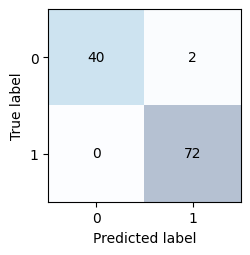

In [4]:
# 図のサイズを指定
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# matshow関数で行列からヒートマップを作成
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

## 指標一覧
誤分類率(ERP)、正解率(ACC)、真陽性率(TPR)、偽陽性率(FPR)、適合率(PRE)、再現率(REC=TPR)、F1スコア、マシューズ相関係数(MCC)

In [5]:
# 適合率、再現率、F1スコア、MCCを計算
# 陽性クラスがクラス1として扱われることに注意

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1 Score: {f1_val:.3f}')
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'Matthews Correlation Coefficient: {mcc_val:.3f}')

Precision: 0.973
Recall: 1.000
F1 Score: 0.986
Matthews Correlation Coefficient: 0.963


In [6]:
# カスタムの性能指標を出力
from sklearn.metrics import make_scorer
c_gamma_range = [0.01, 0.1, 1, 10]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__kernel': ['rbf'], 'svc__gamma': c_gamma_range}]
scorer = make_scorer(f1_score, greater_is_better=True, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print("Best parameters found:")
print(gs.best_params_)
print("Best cross-validation score:")
print(gs.best_score_)

Best parameters found:
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best cross-validation score:
0.9613883268295034


## ROC曲線

ROC(Receiever Operating Characteristic)

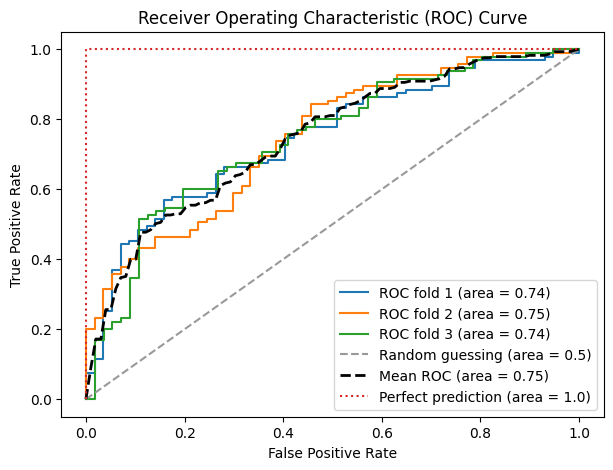

In [8]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
# ROC曲線とAUCを計算

# スケーリング、主成分分析、ロジスティック回帰を指定して、Pipelineを作成
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0)
)

X_train2 = X_train[:, [4, 14]]
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
# 0から1までの間で100個の酵素を生成
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    # predict_probaメソッドを使用して、各分割のROC曲線を計算
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # FPR(X軸)とTPR(Y軸)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)  # AUCを計算
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

# 当て推量をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area = 0.5)')
# 平均ROC曲線をプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

# 完全に予測が正解したときのROC曲線をプロット
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='Perfect prediction (area = 1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## 多クラス分類

sckit-learnはマイクロ平均、マクロ平均も実装している。  
averageパラメータを用いて平均化の方法を指定できる。

## クラスの不均衡に対処する

### 対処法の例
* 少数派クラスに大きなペナルティを科す。（例：class_weight='balanced'）
* 少数派クラスのアップサンプリング、多数派クラスのダウンサンプリング(resample関数)
* 人工的な訓練データの生成。  
さまざまな戦略を試して、それぞれの結果を評価し、最も適切と思われる手法を選択することが推奨される。